In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data.csv')
df.dropna(inplace=True)
df.head()

,revenue,reach,local_tv,online,instore,person,event
0,45860.28,2,31694.91,2115,3296,8,non_event
1,63588.23,2,35040.17,1826,2501,14,special
2,23272.69,4,30992.82,1851,2524,6,special
3,45911.23,2,29417.78,2437,3049,12,special
4,36644.23,2,35611.11,1122,1142,13,cobranding


## 特征对销售额的关联性
reach(微信推送次数)与revenue(门店销售额)有负相关的关系，微信推动次数越多，销售额反而越低。
<br>其余变量与销售额都是正相关关系。其中local_tv(本地电视广告投入)和person(门店销售人员投入)与销售额的正相关性较大。

In [2]:
df.corr()['revenue']

revenue     1.000000
reach      -0.165286
local_tv    0.602114
online      0.174198
instore     0.307361
person      0.557475
Name: revenue, dtype: float64

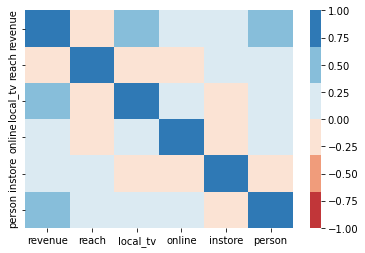

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap=sns.color_palette('RdBu'))
plt.show()

event(门店促销事件)为离散变量，计算其correlation ratio [https://zhuanlan.zhihu.com/p/362258222] 。门店促销事件类型与销售额的关联性低。

In [4]:
import numpy as np
events = df[['event','revenue']]
events_mean = events.groupby(by='event', as_index=False)['revenue'].mean()
events_mean.columns = ['event','group_avg']
events = pd.merge(events, events_mean, on='event', how='left')
events['total_avg'] = df['revenue'].mean()
events['square_diff'] = (events['revenue']-events['total_avg'])**2
events_count = pd.DataFrame(df['event'].value_counts()).reset_index()
events_count.columns = ['event','count']
events_sum = events_count.merge(events_mean, on='event', how='inner')
events_sum['total_avg'] = df['revenue'].mean()
numerator = 0
for i in range(len(events_sum)):
    numerator += events_sum['count'][i]*(events_sum['group_avg'][i]-events_sum['total_avg'][i])**2
np.sqrt(numerator/sum(events['square_diff']))

0.04368009601916971

In [5]:
import altair as alt
alt.Chart(events, width=300).mark_boxplot(
).encode(
    x = 'event', y ='revenue'
)

alt.Chart(...)

## 特征筛选
DictVectorizer结果为9个特征都应该保留

In [6]:
X = df.drop('revenue', axis=1)
y = df['revenue']
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
X = vec.fit_transform(X.to_dict(orient='record'))
len(vec.feature_names_), vec.feature_names_

(9,
 ['event=cobranding',
  'event=holiday',
  'event=non_event',
  'event=special',
  'instore',
  'local_tv',
  'online',
  'person',
  'reach'])

使用SelectKBest保留最主要的4个特征。结果显示最主要的4个特征为local_tv(本地电视广告投入)、online(线上广告投入)、person(门店销售人员投入)、和reach(微信推送次数)。

In [7]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=4)
selector.fit(X,y)
X_new = selector.transform(X)
X_new = pd.DataFrame(X_new.toarray())
X_new

,0,1,2,3
0,31694.91,2115.0,8.0,2.0
1,35040.17,1826.0,14.0,2.0
2,30992.82,1851.0,6.0,4.0
3,29417.78,2437.0,12.0,2.0
4,35611.11,1122.0,13.0,2.0
...,...,...,...,...
924,30527.57,1407.0,12.0,3.0
925,31233.04,1849.0,18.0,2.0
926,34346.13,1200.0,8.0,3.0
927,30215.90,1532.0,16.0,3.0


In [8]:
X_new.columns = ['local_tv','online','person','reach']
X_new

,local_tv,online,person,reach
0,31694.91,2115.0,8.0,2.0
1,35040.17,1826.0,14.0,2.0
2,30992.82,1851.0,6.0,4.0
3,29417.78,2437.0,12.0,2.0
4,35611.11,1122.0,13.0,2.0
...,...,...,...,...
924,30527.57,1407.0,12.0,3.0
925,31233.04,1849.0,18.0,2.0
926,34346.13,1200.0,8.0,3.0
927,30215.90,1532.0,16.0,3.0


## 训练数据测试数据划分

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42, shuffle=True)

## 随机森林

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
score_rf = rf.score(X_train, y_train)
score_rf

0.9476181488347754

In [11]:
MSE_rf = mse(y_test, rf.predict(X_test))
MSE_rf

53635433.91058462

In [12]:
MAE_rf = np.mean(abs(y_test - rf.predict(X_test)))
MAE_rf

5876.683041935483

## SVM

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# svr = Pipeline([
#     ('scaler', StandardScaler()),
#     ('linear_svr', svm.SVR(kernel='linear'))
# ])
svr = svm.SVR(kernel='linear')
svr.fit(X_train, y_train)
score_svr = svr.score(X_train, y_train)
score_svr

0.5988046494640198

In [14]:
MSE_svr = mse(y_test, svr.predict(X_test))
MSE_svr

61664671.877914995

In [15]:
MAE_svr = np.mean(abs(y_test - svr.predict(X_test)))
MAE_svr

6306.673476991544

## xgboost

In [16]:
import xgboost

xgb = xgboost.XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
score_xgb = xgb.score(X_train, y_train)
score_xgb

0.9915167351137204

In [17]:
MSE_xgb = mse(y_test, xgb.predict(X_test))
MSE_xgb

58501712.41569456

In [18]:
MAE_xgb = np.mean(abs(y_test - xgb.predict(X_test)))
MAE_xgb

6201.112864163306

## ANN

In [19]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(random_state=42)
nn.fit(X_train, y_train)
score_nn = nn.score(X_train, y_train)
score_nn

0.34259222301466274

In [20]:
MSE_nn = mse(y_test, nn.predict(X_test))
MSE_nn

89252423.91407908

In [21]:
MAE_nn = np.mean(abs(y_test - nn.predict(X_test)))
MAE_nn

7661.942534641474

## 模型对比

In [22]:
scores = [score_rf, score_svr, score_xgb, score_nn]
MSEs = [MSE_rf, MSE_svr, MSE_xgb, MSE_nn]
MAEs = [MAE_rf, MAE_svr, MAE_xgb, MAE_nn]
summary = pd.DataFrame([scores, MSEs, MAEs], index = ['score','MSE','MAE']).apply(lambda x:round(x,2))
summary.columns = ['随机森林','SVM','XGBoost','Neural Nets']
summary

,随机森林,SVM,XGBoost,Neural Nets
score,0.95,0.60,0.99,0.34
MSE,53635433.91,61664671.88,58501712.42,89252423.91
MAE,5876.68,6306.67,6201.11,7661.94


对比这四个模型，随机森林的结果最好。虽然随机森林的R^2没有XGBoost高，但其MSE（均方误差）和MAE（平均绝对误差）都是四个模型中最低的。